In [1]:
!nvidia-smi

Mon Jan  9 13:36:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   38C    P0    66W / 300W |    954MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   

In [2]:
import os
os.getcwd()

'/home/centos/psw/KSRC'

In [3]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from tqdm import tqdm
import optuna
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer
from tokenizers import Tokenizer
from transformers import PreTrainedTokenizerFast, BartModel



In [4]:
# dpath = '/content/drive/My Drive/Seculayer/KSRC/'
train = pd.read_csv('data/with_kakao_train.csv',encoding='utf-8')
test = pd.read_csv('data/test_data.csv',encoding='utf-8')
train.head()

,Unnamed: 0,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral


In [5]:
# 불 용어 처리 

train['premise'] = train['premise'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
test['premise'] = test['premise'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")
train.head(5)

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


,Unnamed: 0,premise,hypothesis,label
0,0,씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 장정들이 ...,씨름의 여자들의 놀이이다.,contradiction
1,1,삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나 ...,자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면 이런 상황에서는 ...,이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral


In [6]:
train['hypothesis'] = train['hypothesis'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
test['hypothesis'] = test['hypothesis'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")
train.head(5)

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,Unnamed: 0,premise,hypothesis,label
0,0,씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 장정들이 ...,씨름의 여자들의 놀이이다,contradiction
1,1,삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나 ...,자작극을 벌인 이는 3명이다,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다,neutral
4,4,진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면 이런 상황에서는 ...,이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다,neutral


In [7]:
# 결측치는 없음

print(train.info(), end='\n\n')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159475 entries, 0 to 159474
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159475 non-null  int64 
 1   premise     159475 non-null  object
 2   hypothesis  159475 non-null  object
 3   label       159475 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.9+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1666 entries, 0 to 1665
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       1666 non-null   int64 
 1   premise     1666 non-null   object
 2   hypothesis  1666 non-null   object
 3   label       1666 non-null   object
dtypes: int64(1), object(3)
memory usage: 52.2+ KB
None


In [20]:
print('Train Label: ', train['label'].value_counts(), sep='\n', end='\n\n')

Train Label: 
entailment       53618
contradiction    53468
neutral          52389
Name: label, dtype: int64



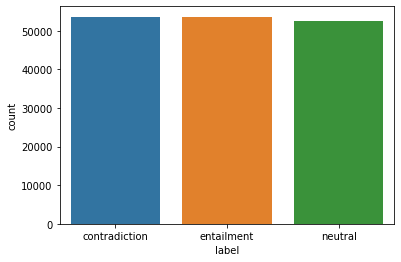

In [21]:
# data imbalance는 사실상 존재하지 않음 

sns.countplot(data=train,x='label');

In [8]:
max_premise = np.max(train['premise'].str.len())

max_hypothesis = np.max(train['hypothesis'].str.len())

In [9]:
print('max premise =',max_premise,"\nmax hypothesis =",max_hypothesis)

max premise = 135 
max hypothesis = 102


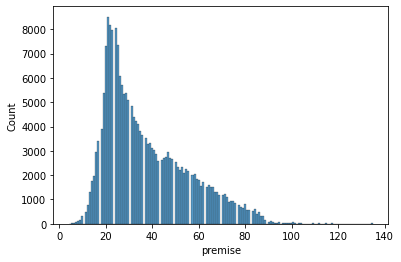

In [17]:
sns.histplot(x=train['premise'].str.len());

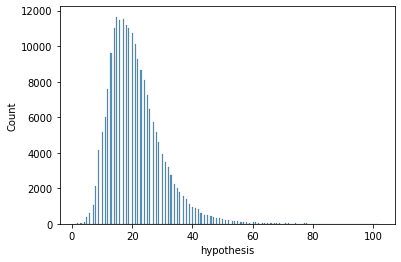

In [18]:
sns.histplot(x=train['hypothesis'].str.len());

In [10]:
def seed_everything(seed:int = 2023):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [11]:
MODEL_NAME = 'tunib/electra-ko-base'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
config = AutoConfig.from_pretrained(MODEL_NAME)

config.num_labels = 3

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

print(model)
print(config)

Some weights of the model checkpoint at tunib/electra-ko-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at tunib/electra-ko-base and are newly initialized: ['classifier.dense.weight', 'classifie

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [12]:
# train test split 및 tokenizing 
# token에 들어가는 문장은 premise와 hypothesis를 concat 한 문장

train_dataset, eval_dataset = train_test_split(train, test_size=0.2, shuffle=True, stratify=train['label'])

tokenized_train = tokenizer(
    list(train_dataset['premise']),
    list(train_dataset['hypothesis']),
    return_tensors="pt",
    max_length=300, # Max_Length = 190
    padding=True,
    truncation=True,
    add_special_tokens=True
)

tokenized_eval = tokenizer(
    list(eval_dataset['premise']),
    list(eval_dataset['hypothesis']),
    return_tensors="pt",
    max_length=300,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

print(tokenized_train['input_ids'][0])
print(tokenizer.decode(tokenized_train['input_ids'][0]))

tensor([    2, 16626,  1992, 19479,  6148, 17858, 11306, 20947,  3554,  6031,
         2188, 13089, 15275,  6148, 13736,  6011,  6692,  6011,     3, 14941,
        16118, 11351, 12195,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
[CLS] 입에 막대기를 물고 있는 개가 얕은 물 속에서 바위를 뛰어다닌다 [SEP] 아무것도 작동하지 않는다 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [13]:
class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, pair_dataset, label):
        self.pair_dataset = pair_dataset
        self.label = label

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.pair_dataset.items()}
        item['label'] = torch.tensor(self.label[idx])
        
        return item

    def __len__(self):
        return len(self.label)
    
def label_to_num(label):
    label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2, "answer": 3}
    num_label = []

    for v in label:
        num_label.append(label_dict[v])

    return num_label


train_label = label_to_num(train_dataset['label'].values)
eval_label = label_to_num(eval_dataset['label'].values)

In [14]:
train_dataset = BERTDataset(tokenized_train, train_label)
eval_dataset = BERTDataset(tokenized_eval, eval_label)

print(train_dataset.__len__())
print(train_dataset.__getitem__(19997))
print(tokenizer.decode(train_dataset.__getitem__(19997)['input_ids']))

127580
{'input_ids': tensor([    2, 13610, 13595, 15049, 12199, 23296, 13163,  3524,  6590,  6015,
        12219, 11392,     3, 20714, 11331, 13610,  6063, 15049, 12199, 13163,
         6007,  3931, 13776, 11884,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [15]:
def compute_metrics(pred):
  """ validation을 위한 metrics function """
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  probs = pred.predictions

  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds) # 리더보드 평가에는 포함되지 않습니다.

  return {
      'accuracy': acc,
  }

In [16]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, 
                                                              config=config)

def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 3e-5, 1.5e-4, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0, 0.01),
#         "num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
#         "seed": trial.suggest_int("seed", 20, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32]),
    }

# def my_hp_space(trial):
#     return {
#         "learning_rate":  trial.suggest_categorical("learning_rate", [0.00001,0.00002, 0.00003,0.00004,0.00005]),
#         "warmup_ratio":  trial.suggest_categorical("warmup_ratio", [0,0.1, 0.2,0.6]),
#         "weight_decay":  trial.suggest_categorical("weight_decay", [0, 0.01]),
# #         "num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
# #         "seed": trial.suggest_int("seed", 20, 40),
#         "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8,16, 32]),
#     }

In [17]:
training_ars = TrainingArguments(
    output_dir='result/electra_hyperparameter_tune/',
    num_train_epochs=7,
    per_device_train_batch_size=32,
    save_total_limit=5,
    save_steps=1200,
    evaluation_strategy='steps',
    eval_steps = 1200,
    load_best_model_at_end = True,
)

trainer = Trainer(
    model_init=model_init,
    args=training_ars,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

loading weights file pytorch_model.bin from cache at /home/centos/.cache/huggingface/hub/models--tunib--electra-ko-base/snapshots/edfb795c9f667b3c5cb7085ca9112997823ce4e8/pytorch_model.bin
Some weights of the model checkpoint at tunib/electra-ko-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
trainer.hyperparameter_search(direction='maximize',
                             backend='optuna',
                             n_trials=10,
                             hp_space=my_hp_space)

[I 2023-01-09 13:37:31,707] A new study created in memory with name: no-name-5a65569d-e038-4199-835f-2da6665e4bbd
Trial: {'learning_rate': 8.94813195527071e-05, 'weight_decay': 0.00011458736482220067, 'per_device_train_batch_size': 32}
loading weights file pytorch_model.bin from cache at /home/centos/.cache/huggingface/hub/models--tunib--electra-ko-base/snapshots/edfb795c9f667b3c5cb7085ca9112997823ce4e8/pytorch_model.bin
Some weights of the model checkpoint at tunib/electra-ko-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS

You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
1200,0.524400,0.492410,0.817432
2400,0.455300,0.437094,0.846183
3600,0.336400,0.389993,0.859100
4800,0.221500,0.447521,0.861859
6000,0.229200,0.510299,0.865841
7200,0.149700,0.455618,0.866907
8400,0.153800,0.545611,0.866437
9600,0.105700,0.504960,0.868036
10800,0.067000,0.697760,0.871892
12000,0.067100,0.718280,0.872770


***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
Saving model checkpoint to result/electra_hyperparameter_tune/run-0/checkpoint-1200
Configuration saved in result/electra_hyperparameter_tune/run-0/checkpoint-1200/config.json
Model weights saved in result/electra_hyperparameter_tune/run-0/checkpoint-1200/pytorch_model.bin
tokenizer config file saved in result/electra_hyperparameter_tune/run-0/checkpoint-1200/tokenizer_config.json
Special tokens file saved in result/electra_hyperparameter_tune/run-0/checkpoint-1200/special_tokens_map.json
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
Saving model checkpoint to result/electra_hyperparameter_tune/r

***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
Saving model checkpoint to result/electra_hyperparameter_tune/run-0/checkpoint-12000
Configuration saved in result/electra_hyperparameter_tune/run-0/checkpoint-12000/config.json
Model weights saved in result/electra_hyperparameter_tune/run-0/checkpoint-12000/pytorch_model.bin
tokenizer config file saved in result/electra_hyperparameter_tune/run-0/checkpoint-12000/tokenizer_config.json
Special tokens file saved in result/electra_hyperparameter_tune/run-0/checkpoint-12000/special_tokens_map.json
Deleting older checkpoint [result/electra_hyperparameter_tune/run-0/checkpoint-7200] due to args.save_total_limit
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Ev

eval/accuracy,▁▅▆▇▇▇▇▇███
eval/loss,▃▂▁▂▃▂▄▃▆▇█
eval/runtime,▂▂▁▁▁▁█▁▂▁▂
eval/samples_per_second,▆▇████▁▇▆▇▇
eval/steps_per_second,▆▇████▁▇▆▇▇
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
train/learning_rate,██▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
train/loss,█▆▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Accuracy
1200,1.099800,1.100148,0.328515
2400,1.099100,1.099792,0.335256
3600,1.099300,1.098713,0.335256
4800,1.099000,1.099270,0.328515
6000,1.098800,1.098690,0.335256
7200,1.098400,1.098572,0.336228
8400,1.098600,1.098587,0.335256
9600,1.098600,1.098673,0.336228
10800,1.098700,1.098589,0.335256
12000,1.098600,1.098724,0.336228


***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
Saving model checkpoint to result/electra_hyperparameter_tune/run-1/checkpoint-1200
Configuration saved in result/electra_hyperparameter_tune/run-1/checkpoint-1200/config.json
Model weights saved in result/electra_hyperparameter_tune/run-1/checkpoint-1200/pytorch_model.bin
tokenizer config file saved in result/electra_hyperparameter_tune/run-1/checkpoint-1200/tokenizer_config.json
Special tokens file saved in result/electra_hyperparameter_tune/run-1/checkpoint-1200/special_tokens_map.json
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
Saving model checkpoint to result/electra_hyperparameter_tune/r

***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
Saving model checkpoint to result/electra_hyperparameter_tune/run-1/checkpoint-12000
Configuration saved in result/electra_hyperparameter_tune/run-1/checkpoint-12000/config.json
Model weights saved in result/electra_hyperparameter_tune/run-1/checkpoint-12000/pytorch_model.bin
tokenizer config file saved in result/electra_hyperparameter_tune/run-1/checkpoint-12000/tokenizer_config.json
Special tokens file saved in result/electra_hyperparameter_tune/run-1/checkpoint-12000/special_tokens_map.json
Deleting older checkpoint [result/electra_hyperparameter_tune/run-1/checkpoint-6000] due to args.save_total_limit
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Ev

tokenizer config file saved in result/electra_hyperparameter_tune/run-1/checkpoint-21600/tokenizer_config.json
Special tokens file saved in result/electra_hyperparameter_tune/run-1/checkpoint-21600/special_tokens_map.json
Deleting older checkpoint [result/electra_hyperparameter_tune/run-1/checkpoint-15600] due to args.save_total_limit
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
Saving model checkpoint to result/electra_hyperparameter_tune/run-1/checkpoint-22800
Configuration saved in result/electra_hyperparameter_tune/run-1/checkpoint-22800/config.json
Model weights saved in result/electra_hyperparameter_tune/run-1/checkpoint-22800/pytorch_model.bin
tokenizer confi

eval/accuracy,▁▇▇▁▇█▇█▇████▇████▇▇███
eval/loss,█▆▂▄▂▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
eval/runtime,▅▃▂▃▃▃▃▃▅▄▄█▇▄▄▃▄▂▁▃▂▂▇
eval/samples_per_second,▄▆▇▆▆▆▆▆▄▄▄▁▂▅▅▅▅▇█▆▇▇▂
eval/steps_per_second,▄▆▇▆▆▆▆▆▄▄▄▁▂▅▅▅▅▇█▆▇▇▂
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▃▃▂▂▂▂▂▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Accuracy
1200,0.533900,0.471414,0.816366
2400,0.478500,0.415638,0.845869
3600,0.423600,0.395608,0.853613
4800,0.303500,0.388986,0.859570
6000,0.304100,0.374445,0.867127
7200,0.304200,0.374441,0.866155
8400,0.292700,0.459371,0.871955
9600,0.209900,0.413407,0.869854
10800,0.200600,0.387477,0.875216
12000,0.210600,0.531806,0.874463


***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
Saving model checkpoint to result/electra_hyperparameter_tune/run-2/checkpoint-1200
Configuration saved in result/electra_hyperparameter_tune/run-2/checkpoint-1200/config.json
Model weights saved in result/electra_hyperparameter_tune/run-2/checkpoint-1200/pytorch_model.bin
tokenizer config file saved in result/electra_hyperparameter_tune/run-2/checkpoint-1200/tokenizer_config.json
Special tokens file saved in result/electra_hyperparameter_tune/run-2/checkpoint-1200/special_tokens_map.json
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
Saving model checkpoint to result/electra_hyperparameter_tune/r

***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
Saving model checkpoint to result/electra_hyperparameter_tune/run-2/checkpoint-12000
Configuration saved in result/electra_hyperparameter_tune/run-2/checkpoint-12000/config.json
Model weights saved in result/electra_hyperparameter_tune/run-2/checkpoint-12000/pytorch_model.bin
tokenizer config file saved in result/electra_hyperparameter_tune/run-2/checkpoint-12000/tokenizer_config.json
Special tokens file saved in result/electra_hyperparameter_tune/run-2/checkpoint-12000/special_tokens_map.json
Deleting older checkpoint [result/electra_hyperparameter_tune/run-2/checkpoint-6000] due to args.save_total_limit
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Ev

tokenizer config file saved in result/electra_hyperparameter_tune/run-2/checkpoint-21600/tokenizer_config.json
Special tokens file saved in result/electra_hyperparameter_tune/run-2/checkpoint-21600/special_tokens_map.json
Deleting older checkpoint [result/electra_hyperparameter_tune/run-2/checkpoint-16800] due to args.save_total_limit
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
Saving model checkpoint to result/electra_hyperparameter_tune/run-2/checkpoint-22800
Configuration saved in result/electra_hyperparameter_tune/run-2/checkpoint-22800/config.json
Model weights saved in result/electra_hyperparameter_tune/run-2/checkpoint-22800/pytorch_model.bin
tokenizer confi

eval/accuracy,▁▄▅▆▇▇▇▇██▇█▇██▇███████
eval/loss,▃▂▁▁▁▁▂▂▁▄▄▃▃▅▄▄▆▆▆▇███
eval/runtime,▁▂▁▃█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
eval/samples_per_second,█▆█▅▁▃▂▃▂▂▂▂▃▂▂▂▃▂▂▃▃▃▂
eval/steps_per_second,█▆█▅▁▃▂▃▂▂▂▂▃▂▂▂▃▂▂▃▃▃▂
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Accuracy
1200,0.568100,0.512239,0.806365
2400,0.507500,0.442713,0.831823
3600,0.451200,0.449455,0.835962
4800,0.327400,0.441452,0.841637
6000,0.331800,0.436949,0.856623
7200,0.334700,0.403872,0.858630
8400,0.312600,0.485469,0.863333
9600,0.231800,0.448747,0.863051
10800,0.225800,0.454360,0.864305
12000,0.231600,0.516856,0.867848


***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
Saving model checkpoint to result/electra_hyperparameter_tune/run-3/checkpoint-1200
Configuration saved in result/electra_hyperparameter_tune/run-3/checkpoint-1200/config.json
Model weights saved in result/electra_hyperparameter_tune/run-3/checkpoint-1200/pytorch_model.bin
tokenizer config file saved in result/electra_hyperparameter_tune/run-3/checkpoint-1200/tokenizer_config.json
Special tokens file saved in result/electra_hyperparameter_tune/run-3/checkpoint-1200/special_tokens_map.json
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
Saving model checkpoint to result/electra_hyperparameter_tune/r

***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
Saving model checkpoint to result/electra_hyperparameter_tune/run-3/checkpoint-12000
Configuration saved in result/electra_hyperparameter_tune/run-3/checkpoint-12000/config.json
Model weights saved in result/electra_hyperparameter_tune/run-3/checkpoint-12000/pytorch_model.bin
tokenizer config file saved in result/electra_hyperparameter_tune/run-3/checkpoint-12000/tokenizer_config.json
Special tokens file saved in result/electra_hyperparameter_tune/run-3/checkpoint-12000/special_tokens_map.json
Deleting older checkpoint [result/electra_hyperparameter_tune/run-3/checkpoint-6000] due to args.save_total_limit
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Ev

tokenizer config file saved in result/electra_hyperparameter_tune/run-3/checkpoint-21600/tokenizer_config.json
Special tokens file saved in result/electra_hyperparameter_tune/run-3/checkpoint-21600/special_tokens_map.json
Deleting older checkpoint [result/electra_hyperparameter_tune/run-3/checkpoint-16800] due to args.save_total_limit
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
Saving model checkpoint to result/electra_hyperparameter_tune/run-3/checkpoint-22800
Configuration saved in result/electra_hyperparameter_tune/run-3/checkpoint-22800/config.json
Model weights saved in result/electra_hyperparameter_tune/run-3/checkpoint-22800/pytorch_model.bin
tokenizer confi

eval/accuracy,▁▄▄▅▆▇▇▇▇▇▇▇███▇███████
eval/loss,▃▂▂▂▂▁▂▂▂▃▄▃▂▄▄▄▆▇▆▇███
eval/runtime,█▆▆▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/samples_per_second,▁▃▂▂███████████████████
eval/steps_per_second,▁▃▂▂███████████████████
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Accuracy
1200,1.099600,1.100513,0.335256
2400,1.099200,1.099706,0.328515
3600,1.098500,1.098591,0.336228
4800,1.098900,1.098763,0.336228
6000,1.098800,1.098714,0.336228
7200,1.098700,1.098586,0.336228
8400,1.098600,1.098644,0.335256
9600,1.098700,1.098560,0.336228
10800,1.098700,1.098588,0.336228
12000,1.098600,1.098587,0.335256


***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
Saving model checkpoint to result/electra_hyperparameter_tune/run-4/checkpoint-1200
Configuration saved in result/electra_hyperparameter_tune/run-4/checkpoint-1200/config.json
Model weights saved in result/electra_hyperparameter_tune/run-4/checkpoint-1200/pytorch_model.bin
tokenizer config file saved in result/electra_hyperparameter_tune/run-4/checkpoint-1200/tokenizer_config.json
Special tokens file saved in result/electra_hyperparameter_tune/run-4/checkpoint-1200/special_tokens_map.json
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
Saving model checkpoint to result/electra_hyperparameter_tune/r

***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
Saving model checkpoint to result/electra_hyperparameter_tune/run-4/checkpoint-12000
Configuration saved in result/electra_hyperparameter_tune/run-4/checkpoint-12000/config.json
Model weights saved in result/electra_hyperparameter_tune/run-4/checkpoint-12000/pytorch_model.bin
tokenizer config file saved in result/electra_hyperparameter_tune/run-4/checkpoint-12000/tokenizer_config.json
Special tokens file saved in result/electra_hyperparameter_tune/run-4/checkpoint-12000/special_tokens_map.json
Deleting older checkpoint [result/electra_hyperparameter_tune/run-4/checkpoint-6000] due to args.save_total_limit
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Ev

eval/accuracy,▇▁████▇██▇▇
eval/loss,█▅▁▂▂▁▁▁▁▁▁
eval/runtime,▄▁▇▄▅▆▇█▆▃▅
eval/samples_per_second,▅█▂▅▄▃▂▁▃▆▃
eval/steps_per_second,▅█▂▅▄▃▂▁▃▆▃
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
train/learning_rate,██▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
train/loss,█▄▃▃▃▂▁▂▂▂▂▂▂▂▂▁▂▁▂▁▂▂▁▁▂▁▁
train/total_flos,▁
train/train_loss,▁


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Accuracy
1200,1.099900,1.100556,0.328515


***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
[I 2023-01-09 23:43:12,187] Trial 5 pruned. 
Trial: {'learning_rate': 7.346951137691866e-05, 'weight_decay': 0.00577990236203565, 'per_device_train_batch_size': 16}
loading weights file pytorch_model.bin from cache at /home/centos/.cache/huggingface/hub/models--tunib--electra-ko-base/snapshots/edfb795c9f667b3c5cb7085ca9112997823ce4e8/pytorch_model.bin
Some weights of the model checkpoint at tunib/electra-ko-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This I

eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▆█
train/global_step,▁▆█
train/learning_rate,█▁
train/loss,█▁
eval/accuracy,0.32852
eval/loss,1.10056


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Accuracy
1200,0.582600,0.504765,0.805142


***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
[I 2023-01-09 23:48:41,389] Trial 6 pruned. 
Trial: {'learning_rate': 0.00012651051165973913, 'weight_decay': 0.008071571145432364, 'per_device_train_batch_size': 32}
loading weights file pytorch_model.bin from cache at /home/centos/.cache/huggingface/hub/models--tunib--electra-ko-base/snapshots/edfb795c9f667b3c5cb7085ca9112997823ce4e8/pytorch_model.bin
Some weights of the model checkpoint at tunib/electra-ko-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This

eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▆█
train/global_step,▁▆█
train/learning_rate,█▁
train/loss,█▁
eval/accuracy,0.80514
eval/loss,0.50477


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Accuracy
1200,1.099500,1.100233,0.335256


***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
[I 2023-01-09 23:55:23,632] Trial 7 pruned. 
Trial: {'learning_rate': 0.0001430781750558233, 'weight_decay': 0.009059199019340488, 'per_device_train_batch_size': 32}
loading weights file pytorch_model.bin from cache at /home/centos/.cache/huggingface/hub/models--tunib--electra-ko-base/snapshots/edfb795c9f667b3c5cb7085ca9112997823ce4e8/pytorch_model.bin
Some weights of the model checkpoint at tunib/electra-ko-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This 

eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▆█
train/global_step,▁▆█
train/learning_rate,█▁
train/loss,█▁
eval/accuracy,0.33526
eval/loss,1.10023


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Accuracy
1200,1.099500,1.100165,0.335256


***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
[I 2023-01-10 00:02:08,157] Trial 8 pruned. 
Trial: {'learning_rate': 6.394475774825806e-05, 'weight_decay': 0.0009238250281285176, 'per_device_train_batch_size': 32}
loading weights file pytorch_model.bin from cache at /home/centos/.cache/huggingface/hub/models--tunib--electra-ko-base/snapshots/edfb795c9f667b3c5cb7085ca9112997823ce4e8/pytorch_model.bin
Some weights of the model checkpoint at tunib/electra-ko-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This

eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▆█
train/global_step,▁▆█
train/learning_rate,█▁
train/loss,█▁
eval/accuracy,0.33526
eval/loss,1.10016


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Accuracy
1200,1.099500,1.100384,0.335256


***** Running Evaluation *****
  Num examples = 31895
  Batch size = 16
[I 2023-01-10 00:08:52,139] Trial 9 pruned. 


BestRun(run_id='2', objective=0.8750587866436745, hyperparameters={'learning_rate': 3.213114421183878e-05, 'weight_decay': 0.009872847838692694, 'per_device_train_batch_size': 16})

wandb: ERROR Error while calling W&B API: internal database error (<Response [500]>)


In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Tokenizer_NAME = "tunib/electra-ko-base"
tokenizer = AutoTokenizer.from_pretrained(Tokenizer_NAME)

MODEL_NAME = 'result/electra_hyperparameter_tune/run-2/checkpoint-7200'
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.resize_token_embeddings(tokenizer.vocab_size)
model.to(device)

print(tokenizer)

loading configuration file config.json from cache at /home/centos/.cache/huggingface/hub/models--tunib--electra-ko-base/snapshots/edfb795c9f667b3c5cb7085ca9112997823ce4e8/config.json
Model config ElectraConfig {
  "_name_or_path": "tunib/electra-ko-base",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading file vocab.txt from cach

PreTrainedTokenizerFast(name_or_path='tunib/electra-ko-base', vocab_size=32000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [20]:
test_label = label_to_num(test['label'].values)

tokenized_test = tokenizer(
    list(test['premise']),
    list(test['hypothesis']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

test_dataset = BERTDataset(tokenized_test, test_label)

print(test_dataset.__len__())
print(test_dataset.__getitem__(1665))
print(tokenizer.decode(test_dataset.__getitem__(6)['input_ids']))

1666
{'input_ids': tensor([    2,   791, 14921, 23745,  6237,   485, 15213,  2137,   204,  8377,
        11304,     3,   791, 14921,  1485,  6020, 11461,  6015, 14521, 13377,
            3,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [21]:
dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
output_pred = []
output_prob = []

for i, data in enumerate(tqdm(dataloader)):
    with torch.no_grad():
        outputs = model(
            input_ids=data['input_ids'].to(device),
            attention_mask=data['attention_mask'].to(device),
            token_type_ids=data['token_type_ids'].to(device)
        )
    logits = outputs[0]
    prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits, axis=-1)

    output_pred.append(result)
    output_prob.append(prob)
  
pred_answer, output_prob = np.concatenate(output_pred).tolist(), np.concatenate(output_prob, axis=0).tolist()
print(pred_answer)

100%|██████████| 105/105 [00:02<00:00, 44.00it/s]

[1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 0, 1, 0, 2, 2, 0, 2, 1, 2, 1, 2, 0, 0, 1, 2, 2, 0, 0, 0, 1, 0, 1, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 1, 2, 0, 1, 0, 2, 1, 1, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 0, 1, 2, 2, 0, 2, 2, 1, 2, 2, 1, 1, 0, 1, 2, 1, 0, 2, 1, 2, 0, 1, 0, 0, 1, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 1, 0, 1, 2, 1, 0, 2, 0, 0, 1, 1, 1, 1, 2, 1, 2, 2, 2, 0, 1, 1, 2, 1, 2, 1, 0, 2, 0, 0, 2, 1, 1, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 0, 1, 2, 0, 1, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 1, 1, 0, 0, 2, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 2, 0, 1, 2, 1, 1, 2, 1, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 2, 2, 2, 0, 2, 2, 2, 1, 0, 1, 2, 0, 2, 2, 2, 1, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 1, 1, 1, 2, 2, 2, 0, 2, 0, 1, 0, 2, 1, 0, 2, 0, 1, 0, 2, 0, 1, 1, 1, 2, 2, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 2, 1, 1, 2, 0, 0, 

In [27]:
output_prob[0]

[0.000503677292726934, 0.9964536428451538, 0.0030427409801632166]

In [35]:
df = pd.DataFrame(prob_of_output, columns=['index', 'prob'])
df.head()

,index,prob
0,0,"[0.000503677292726934, 0.9964536428451538, 0.0..."
1,1,"[0.053734514862298965, 0.002680903533473611, 0..."
2,2,"[0.011614812538027763, 0.003720239968970418, 0..."
3,3,"[0.0011501049157232046, 0.9467388391494751, 0...."
4,4,"[0.012297039851546288, 0.9785420894622803, 0.0..."


In [32]:
prob_of_output = []
for i, v in enumerate(output_prob):
    prob_of_output.append([i,v])
    

In [33]:
prob_of_output

[[0, [0.000503677292726934, 0.9964536428451538, 0.0030427409801632166]],
 [1, [0.053734514862298965, 0.002680903533473611, 0.9435845017433167]],
 [2, [0.011614812538027763, 0.003720239968970418, 0.9846648573875427]],
 [3, [0.0011501049157232046, 0.9467388391494751, 0.052111007273197174]],
 [4, [0.012297039851546288, 0.9785420894622803, 0.009160801768302917]],
 [5, [0.002121122321113944, 0.7874798774719238, 0.21039903163909912]],
 [6, [0.007405277341604233, 0.007436033338308334, 0.9851586222648621]],
 [7, [0.3682658076286316, 0.4189690351486206, 0.212765172123909]],
 [8, [0.9745813012123108, 0.002231544116511941, 0.023187166079878807]],
 [9, [0.07236459851264954, 0.7306638360023499, 0.19697163999080658]],
 [10, [0.00907385628670454, 0.9000028371810913, 0.0909232422709465]],
 [11, [0.9796241521835327, 0.0037880379240959883, 0.01658778265118599]],
 [12, [0.00038295050035230815, 0.9957523345947266, 0.0038646692410111427]],
 [13, [0.9867089986801147, 0.00841760728508234, 0.00487349182367324

In [22]:
def num_to_label(label):
    label_dict = {0: "entailment", 1: "contradiction", 2: "neutral"}
    str_label = []

    for i, v in enumerate(label):
        str_label.append([i,label_dict[v]])
    
    return str_label

answer = num_to_label(pred_answer)
print(answer)

[[0, 'contradiction'], [1, 'neutral'], [2, 'neutral'], [3, 'contradiction'], [4, 'contradiction'], [5, 'contradiction'], [6, 'neutral'], [7, 'contradiction'], [8, 'entailment'], [9, 'contradiction'], [10, 'contradiction'], [11, 'entailment'], [12, 'contradiction'], [13, 'entailment'], [14, 'neutral'], [15, 'neutral'], [16, 'entailment'], [17, 'neutral'], [18, 'contradiction'], [19, 'neutral'], [20, 'contradiction'], [21, 'neutral'], [22, 'entailment'], [23, 'entailment'], [24, 'contradiction'], [25, 'neutral'], [26, 'neutral'], [27, 'entailment'], [28, 'entailment'], [29, 'entailment'], [30, 'contradiction'], [31, 'entailment'], [32, 'contradiction'], [33, 'neutral'], [34, 'neutral'], [35, 'neutral'], [36, 'neutral'], [37, 'contradiction'], [38, 'entailment'], [39, 'contradiction'], [40, 'neutral'], [41, 'neutral'], [42, 'neutral'], [43, 'neutral'], [44, 'neutral'], [45, 'contradiction'], [46, 'neutral'], [47, 'entailment'], [48, 'contradiction'], [49, 'entailment'], [50, 'neutral'], [

In [23]:
df = pd.DataFrame(answer, columns=['index', 'label'])

df.to_csv('electra_hyperparameter_tune.csv', index=False)

print(df)

      index          label
0         0  contradiction
1         1        neutral
2         2        neutral
3         3  contradiction
4         4  contradiction
...     ...            ...
1661   1661        neutral
1662   1662        neutral
1663   1663        neutral
1664   1664        neutral
1665   1665        neutral

[1666 rows x 2 columns]
